In [ ]:
# Automatically evaluates the semantic similarity between biomedical hypotheses and background information.
import json
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer, util

In [2]:
# ==== Configuration ====
# STANDARD_FILE   = "../results/gold_hypo.jsonl" 
# GENERATED_FILE  = "../results/model_hypo.jsonl"
STANDARD_FILE   = "../data/data_raw/temp_filtered_background.jsonl" 
GENERATED_FILE  = "../data/data_raw/temp_raw.jsonl"
MODEL_NAME      = "pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb"

In [3]:
def parse_hypotheses(hyp_str: str): 
    # extract
    return [m.strip() for m in re.findall(r'\(\d+\)\s*([^()]+)', hyp_str)]

def load_gold(path: str): 
    # parse
    hypotheses = []
    backgrounds = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            data = json.loads(line)
            hyps = parse_hypotheses(data.get("hypothesis", ""))
            bgs = data.get("background", "").strip()
            hypotheses.append(hyps)
            backgrounds.append(bgs)
    return hypotheses, backgrounds

def load_gen(path: str): 
    # parse
    hypotheses = []
    backgrounds = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            data = json.loads(line)
            hyps = data.get("final_hypothesis", "")
            bgs = data.get("background", "").strip()
            hypotheses.append(hyps)
            backgrounds.append(bgs)
    return hypotheses, backgrounds

In [4]:
gold_groups, _ = load_gold(STANDARD_FILE)
gen_groups, _ = load_gen(GENERATED_FILE)

In [5]:
len(gold_groups), len(gen_groups)

(134, 134)

### Cosine Similarity

In [6]:
model = SentenceTransformer(MODEL_NAME)

In [7]:
model_gold = []

gold_store = []

for gen_set, gold_set in zip(gen_groups, gold_groups):
    emb_gen = model.encode(gen_set, convert_to_tensor=True).cpu()
    emb_gold = model.encode(gold_set, convert_to_tensor=True).cpu()

    sim_matrix = util.cos_sim(emb_gen, emb_gold).cpu().numpy()
    
    model_gold.append(sim_matrix.max(axis=1))

    gold_store.append(np.array(gold_set)[sim_matrix.argmax(axis=1)])

model_gold = np.concatenate(model_gold)

gold_store = np.concatenate(gold_store)

C:\Users\yujingke\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [8]:
len(model_gold)

134

In [9]:
gold_gold = []
for i in range(len(gold_groups)):
    for j in range(i+1, len(gold_groups)):

        emb_i = model.encode(gold_groups[i], convert_to_tensor=True)
        emb_j = model.encode(gold_groups[j], convert_to_tensor=True)
        sim_matrix = util.cos_sim(emb_i, emb_j).cpu().numpy()
        
        avg_score = sim_matrix.max()

        gold_gold.append(avg_score)

In [10]:
len(gold_gold) 

8911

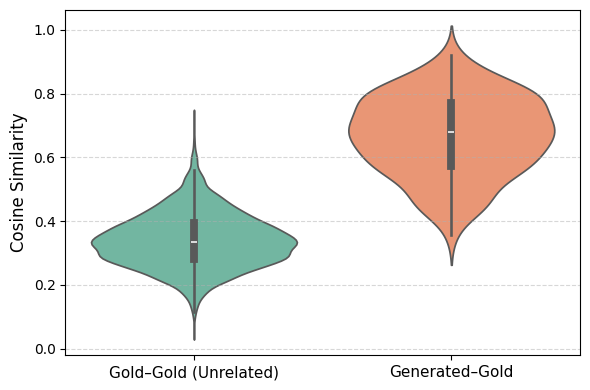

In [11]:
data = [gold_gold, model_gold]
labels = ['Gold–Gold (Unrelated)', 'Generated–Gold']

plt.figure(figsize=(6, 4))
sns.violinplot(data=data, inner="box", palette="Set2")
plt.xticks(ticks=[0, 1], labels=labels, fontsize=11)
plt.ylabel("Cosine Similarity", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
# plt.savefig("temporal-eval.pdf", format="pdf")
plt.show()

In [12]:
import pandas as pd
# Save data with different lengths using separate DataFrames
# pd.DataFrame({"Gold–Gold (Unrelated)": gold_gold}).to_csv("../results/gold_gold.csv", index=False)
# pd.DataFrame({"Generated–Gold": model_gold}).to_csv("../results/model_gold.csv", index=False)

# Or save as a single file with NaN padding
max_len = max(len(gold_gold), len(model_gold))
data_dict = {
    "Gold–Gold (Unrelated)": gold_gold + [np.nan] * (max_len - len(gold_gold)),
    "Generated–Gold": list(model_gold) + [np.nan] * (max_len - len(model_gold))
}
pd.DataFrame(data_dict).to_csv("temporal-eval.csv", index=False)